In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import sqlite3

sys.path.insert(0, '/home/nsryan/Desktop/arfc/transition-scenarios/scripts')
mycolors = ["#332288", "#117733", "#44AA99", "#88CCEE", "#DDCC77", "#CC6677", "#AA4499", "#882255"]
plt.rcParams.update({'font.size': 15})

In [5]:
import cymetric as cym
import transition_metrics as tm
import dataframe_analysis as dta

import waste_calcs

## Scope

This single MMR-like simulation is to establish BOE calculations. One MMR-like reactor is deployed in 1965 and operates for 20 years without shutting down. There is one mine, mill, conversion facility, enrichment facility, fuel fabrication facility, and repository.

In this notebook, I will test each of the analyses that I will perform on multi-reactor simulations to ensure they match back-of-the-envelope calculations.

## Reactor Deployment

In [10]:
current_outfile = 'output_files/single_voygr1.sqlite'

In [11]:
current_mmr = ['Mine', 'Mill', 'Conversion',
               'Enrichment', 'FuelFab', 'United States Nuclear',
               'USA', 'VOYGR', 'NuclearRepository', 'Reactors']

In [12]:
current_reactors = tm.get_prototype_totals(current_outfile, current_mmr, ['VOYGR'])
current_reactors = dta.add_year(current_reactors)

No agents were decommissioned during this simulation.


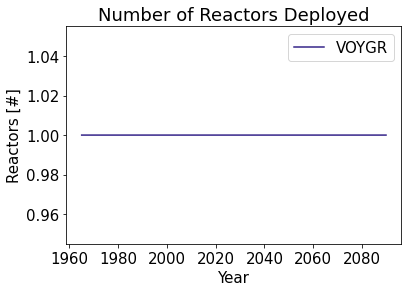

In [13]:
plt.plot(current_reactors['Year'], current_reactors['VOYGR_total'], label='VOYGR', color=mycolors[0])
plt.title('Number of Reactors Deployed')
plt.xlabel('Year')
plt.ylabel('Reactors [#]')
plt.legend()

## Energy Output

In [7]:
current_energy = tm.get_annual_electricity(current_outfile)

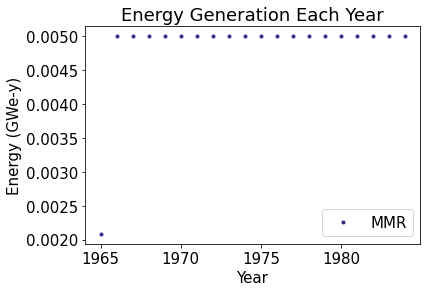

In [8]:
# Plot the yearly energy

plt.plot(current_energy['Year'], current_energy['Energy'],'.', label='MMR', color=mycolors[0])

plt.title('Energy Generation Each Year')
plt.xlabel('Year')
plt.ylabel('Energy (GWe-y)')
plt.legend()

## Material Transactions

In [9]:
current_transactions = tm.add_receiver_prototype(current_outfile)

In [10]:
current_uox = dta.commodity_mass_traded(current_transactions, 'fresh_uox')

Maximum mass: 0.54
Total mass: 0       0.00
1       0.00
2       0.00
3       0.00
4       0.00
        ... 
1495    0.54
1496    0.54
1497    0.54
1498    0.54
1499    0.54
Name: Quantity, Length: 1500, dtype: float64


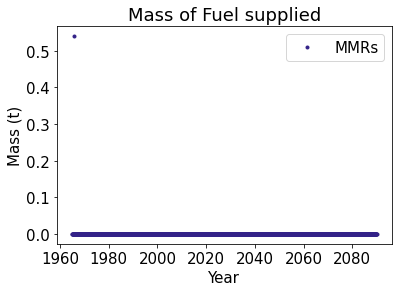

In [11]:
# Comparing fresh_uox transactions to all reactors

plt.plot(current_uox['Year'], current_uox['Quantity']/1000,'.',
         label='MMRs', color=mycolors[0])
plt.legend() #(loc=2)
plt.ylabel('Mass (t)')
plt.xlabel('Year')
plt.title('Mass of Fuel supplied')

print('Maximum mass:',max(current_uox['Quantity']/1000))
print('Total mass:',current_uox['Quantity'].cumsum()/1000)

Text(0.5, 1.0, 'Cumulative Mass of UOx supplied')

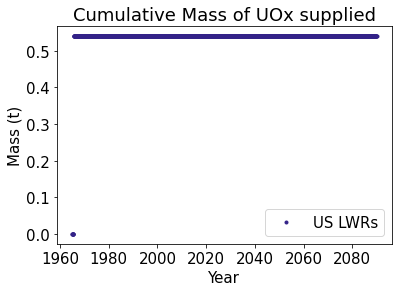

In [12]:
plt.plot(current_uox['Year'], current_uox['Quantity'].cumsum()/1000,'.',
         label='US LWRs', color=mycolors[0])
plt.legend()
plt.ylabel('Mass (t)')
plt.xlabel('Year')
plt.title('Cumulative Mass of TRISO supplied')

## SWU Calcs
SWU = $(P*V(x_p) + T*V(x_t) - F*V(x_f))*t$

V($x_i$) = $(2*x_i-1)*\ln(x_i/(1-x_i))$

In [14]:
# Defining assays for LEU product, tails, and feed material
# Made up values
leu_p = 0.13
x_f = 0.00711
x_t = 0.002

In [15]:
current_tails = dta.calculate_tails(current_uox['Quantity'], leu_p, x_t, x_f)
current_feed = dta.calculate_feed(current_uox['Quantity'], current_tails)
current_swu = dta.calculate_SWU(current_uox['Quantity'], leu_p,
                               current_tails, x_t,
                               current_feed, x_f)
current_swu = current_swu.to_frame().reset_index()
current_swu = current_swu.rename(columns={'Quantity':'SWU', 'index':'Time'})
current_swu = dta.add_year(current_swu)

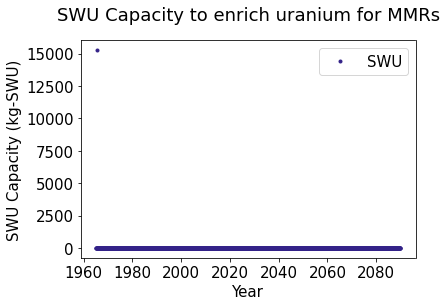

In [16]:
plt.plot(current_swu['Year'], current_swu['SWU'], '.', label='SWU', color=mycolors[0])

plt.xlabel('Year')
plt.ylabel('SWU Capacity (kg-SWU)')
title = plt.title('SWU Capacity to enrich uranium for MMRs', pad=20)
plt.legend()

## Waste Calcs

In [17]:
spent_haleu = dta.commodity_mass_traded(current_transactions, 'spent_haleu_triso')

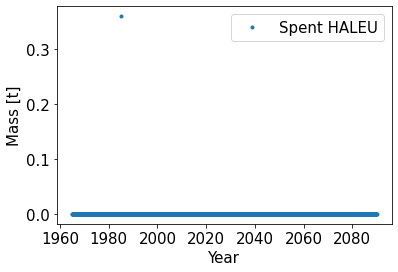

In [18]:
plt.plot(spent_haleu['Year'], spent_haleu['Quantity']/1000,'.', label='Spent HALEU')

plt.ylabel('Mass [t]')
plt.xlabel('Year')
plt.legend()

In [19]:
w = spent_haleu.to_dict()

# create the empty waste dictionary
waste = {'Year':np.zeros(len(w['Year'])),
        'Quantity':np.zeros(len(w['Year']))}

# populate the waste dictionary with the spent_uox values
for year in range(len(w['Year'])):
    waste['Year'][year] = w['Year'][year]
    waste['Quantity'][year] = w['Quantity'][year]/1000 # mass in tons

# convevert the waste dictionary into masses in the format that Cask_Calcs requires
masses = {year: quantity for year, quantity in zip(waste['Year'], waste['Quantity'])}

In [20]:
# numbers are made up

elements = 'prism'
cask_vol = 12.0
den_kernel = 2
vol_kernel = 0.1
mass_kernel = 0.2
vol_triso = 1
mass_triso = 0.4
den_triso = 1.2
vol_prism = 12.0
mass_prism = 0.11

casks_test = waste_calcs.Cask_Calcs(elements,  masses, cask_vol,
                 vol_prism, mass_prism)

In [21]:
num_casks = casks_test.calculate_casks()

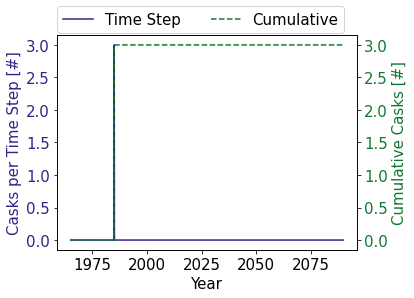

With a leftover of: 0.27272727272727204


In [22]:
fig, ax1 = plt.subplots()

color = mycolors[0]
ax1.set_xlabel('Year')
ax1.set_ylabel('Casks per Time Step [#]', color=color)
ax1.plot(waste['Year'], num_casks[0], color=color, label='Time Step')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = mycolors[1]
ax2.set_ylabel('Cumulative Casks [#]', color=color)
ax2.plot(waste['Year'], num_casks[0].cumsum(), color=color, label='Cumulative', linestyle='--')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
fig.legend(loc='upper center', bbox_to_anchor=(0.485, 1.07), ncol=2)
plt.show()
print('With a leftover of:', num_casks[1][-1])